# DTSA-5510 Week 4 Programming Assignment: BBC News Classification
### May 29, 2022


# NOTE: Part 2 is at the bottom of this notebook!


## Part 1:  Matrix Factorization of BBC News Stories - A Kaggle Competition
### Introduction

This is the Week 3 project for DTSA-5510, Unsupervised Algorithms in Machine Learning, and performs unsupervised learning algorithms to [BBC news stories](https://www.kaggle.com/competitions/learn-ai-bbc/overview) from a machine learning competition on [Kaggle](https://www.kaggle.com).
  
This project attempts to categorize or cluster BBC news stories based on the textual content of the story. After binning the stories, the bins are assigned the category names based on the highest predictive score and then these names are compared to the test data to determine the accuracy of the unsupervised learning method.

This Jupyter notebook along with the data used to this create report can be found at and cloned from https://github.com/clayv/DTSA-5510_Week_4.

**References:**  
Beysolow, T. (2018). _Applied Natural Language Processing with Python_. Apress  
Nixon, A. (2020, August 28). Building a movie content based recommender using tf-idf. Towards Data Science. https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5


In [1]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics 

#Set a global random state (set to 'None' if reproducible results are not desired)
randomState = 42

### Step 0: Load the data

In [2]:
df_train = pd.read_csv("data/BBC News Train.csv.zip", compression="zip")
df_test = pd.read_csv("data/BBC News Test.csv.zip", compression="zip")
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Step 1: Extracting word features and show Exploratory Data Analysis (EDA)
The data appeared well maintained already with no null values in either of the training or testing data sets.

All the training data is therefore classified (in the Category) column and a call to unique() will tell us the Category names.

In [3]:
topics = df_train["Category"].unique()

print(topics.tolist())
print()
print(df_train.info())
print()
print(df_test.info())

['business', 'tech', 'politics', 'sport', 'entertainment']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


In [4]:
#df_train["Category"] = df_train["Category"].astype("category")


#### Histograms and Data Cleaning
To get a better idea of the content of each category, a histogram of each categories top 20 words is plotted. Some common terms such as "new", "said", and "year" were intially cleaned from the data set in the cleanDataset function. But you'll notice those lines are now commented out as it was discovered leaving them in and then adjusting the maxDf hyperparameter (more on that later) gave a higher accuracy.

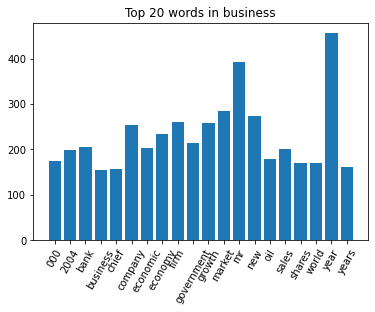

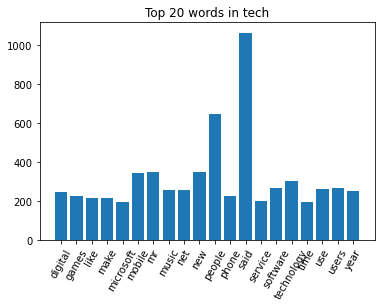

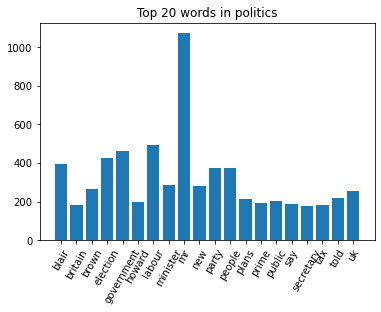

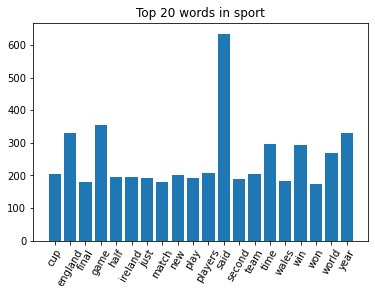

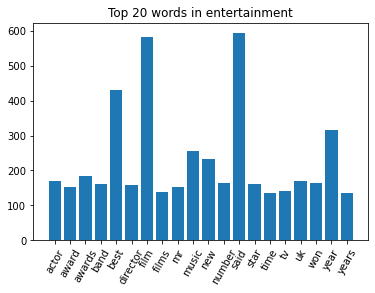

In [4]:
n_topWords = 20
    
def replaceInDataframe(df, replace, to):
    df.replace(to_replace = replace, value = to, inplace = True, regex = True)

def cleanDataset(df):
    replaceInDataframe(df, "’", "\'")
#    replaceInDataframe(df, "\\s+mr\\s+", "")
#    replaceInDataframe(df, "\\s+new\\s+", "")
#    replaceInDataframe(df, "\\s+said", "")
#    replaceInDataframe(df, "\\s+year", "")
    replaceInDataframe(df, "\\d+", "")

def plotTopicHistogram(topic):
    temp_df = df_train.loc[df_train["Category"] == topic]["Text"]
    tf = tf_vectorizer.fit_transform(temp_df)
    plt.title("Top {} words in {}".format(n_topWords, topic))
    plt.bar(x = tf_vectorizer.get_feature_names_out(), height = np.sum(tf.toarray(), axis=0))
    plt.xticks(rotation = 60)
    plt.show()       
    
tf_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = n_topWords, stop_words = "english")
for topic in topics:
    plotTopicHistogram(topic)

#Clean the data!    
cleanDataset(df_train)
cleanDataset(df_test)


In [5]:
# Helper functions

def makeLabelDict(labels):
    workingDict = {}
    for i in range(len(labels)):
        workingDict[i] = labels[i]
    return workingDict        

def label_permute_compare(ytdf, yp, labelDict):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    permutations = list(itertools.permutations(range(len(labelDict))))
    order = []
    highAcc = 0
    length = len(yp)
    for permutation in permutations:
        mapping = np.empty(length, dtype = object)
        for i in range(length):
            mapping[i] = labelDict[permutation[yp[i]]]
        acc = metrics.accuracy_score(ytdf, mapping)
        if acc > highAcc:
            highAcc = acc
            order = permutation
    return order, highAcc       

def fitNMF(tfidf, n_topicLabels, alpha, lossFunc, solverArg):
    #print("Fitting the NMF model with {} loss function and solver {}".format(lossFunc, solverArg))
    nmf = NMF(
        n_components = n_topicLabels,
        random_state = randomState,
        init = "nndsvda",
        beta_loss = lossFunc,
        solver = solverArg,
        max_iter = 1000,
        alpha_W = alpha,
        alpha_H = alpha,
        l1_ratio = 0.5,
    ).fit(tfidf)
    return nmf

def predictions(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

def outputModel(model, labelMap, labelDict):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print()
    for topic_idx, topic in enumerate(model.components_):
        print("Label: {}".format(labelDict[labelMap[topic_idx]]))
        print(" ".join([feature_names[i]
            for i in topic.argsort()[:-n_topWords - 1:-1]]))
        print()


### Step 2: Building and Training Models
I chose Non-Negative Matrix Factorization as my factorization method for the unsupervised learning approach. When training this model I used the only training data sets.  I chose this method because I would like to see how the model will perform on data not yet created.  This would be useful to properly place articles in the correct section of an online newspaper or to suggest new articles as they are written to the readers.

The accuracy on the training data using this technique was $\approx$ 0.9497 and Kaggle reported the accuracy on the testing data as $\approx$ 0.9320.  This accuracy level was achieved after some experimentation with the parameters to the TfidfVectorizer and essentially _not_ cleaning the data sets.

Initially, the data sets were cleaned of words that occurred frequently (see histograms above) such as "new", "said", and "year" and the max_df of the TfidfVectorizer was set to 0.95.  But I found that leaving the frequent words in the data set and lowering the max_df to 0.90 increased the accuracy on the training data from $\approx$ 0.943 to the 0.9497 figure given earlier.

In [6]:
topicDict = makeLabelDict(topics)
n_topics = len(topics)
n_maxFeatures = n_topics * n_topWords * 10 # 5 x 20 x 10 = 1000

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = n_maxFeatures, stop_words = "english")

tfidf_train = tfidf_vectorizer.fit_transform(df_train["Text"])
nmfModel = fitNMF(tfidf_train, n_topics, 0.00005, "kullback-leibler", "mu")

y_hatTrain = predictions(nmfModel.transform(tfidf_train))
labelOrder, acc = label_permute_compare(df_train["Category"], y_hatTrain, topicDict)
print("Got accuracy of: {}".format(acc))

predTrain = []
for i in y_hatTrain:
    predTrain.append(topicDict[labelOrder[i]])
print("Confusion Matrix:")
print(metrics.confusion_matrix(df_train["Category"], predTrain))

outputModel(nmfModel, labelOrder, topicDict)


Extracting tf-idf features for NMF...
Got accuracy of: 0.9496644295302014
Confusion Matrix:
[[314   0  12   1   9]
 [  1 258  10   0   4]
 [ 13   0 259   0   2]
 [  1   3   1 341   0]
 [  4   4   6   4 243]]

Label: business
bn said company firm market year growth bank economy shares sales china oil deal mr economic india financial business prices

Label: sport
game england win said club team cup players world match season time play final ireland chelsea injury wales year half

Label: politics
mr said labour election government blair party brown minister people prime public howard law secretary police plans tax lord told

Label: entertainment
film best awards music star band award actor films tv album year singer said festival oscar won number director chart

Label: tech
people mobile said technology phone software users digital use internet computer online microsoft net service games music mail information search



In [7]:
# Test the model fitted above

# Use the same vectorizer, but only call transfrom instead of fit_transform
tfidf_test = tfidf_vectorizer.transform(df_test["Text"])

# Use the same nmfmodel (note no call to the fitNMF helper function)
y_hatTest = predictions(nmfModel.transform(tfidf_test))

# Generate the CSV file for submission to Kaggle
predTest = []
for i in y_hatTest:
    predTest.append(topicDict[labelOrder[i]])
data = {'ArticleId':df_test.ArticleId, 'Category':predTest}
df = pd.DataFrame(data)
try:
    df.to_csv("C:\\Users\\clayv\Desktop\\BBCNews.csv", index = False)
except:
    pass
print("TF-IDF Vectorizer trained with with only test dataset when submitted got accuracy score of: 0.93197")

TF-IDF Vectorizer trained with with only test dataset when submitted got accuracy score of: 0.93197


#### Trying different hyperparameters
When trying different hyperparameters, I was able to find a combination that gave a higher accuracy than $\approx$ 0.9497. By using kullback-leibler loss finction, the "mu", and an alpha of 0.00009 an accuracy of $\approx$ 0.9503 was achieved. A table of the parameters tried is below and this is after the aforementioned tuning of the TfidfVectorizer and "uncleaning" the data.

In [9]:
lossFuncs = ["frobenius", "kullback-leibler", "itakura-saito"]
solvers = ["cd", "mu"]
alphas = np.arange(0.0, 0.00010, 0.00001)
maxAcc = 0
print("Loss Function\tSolver\tAlpha\t\t\t\tAccuracy")
for lossFunc in lossFuncs:
    for solver in solvers:
        for alpha in alphas:
            try:
                nmfModel = fitNMF(tfidf_train, n_topics, alpha, lossFunc, solver)
                predictedTopics = predictions(nmfModel.transform(tfidf_train))
                labelOrder, acc = label_permute_compare(df_train["Category"], predictedTopics, topicDict)
                print("{}\t{}\t{}\t\t\t\t{}".format(lossFunc, solver, alpha, acc))
                if acc > maxAcc:
                    bestLossFunc, bestSolver, bestAlpha, maxAcc = lossFunc, solver, alpha, acc
            except:
                pass
print()
print("Highest accuracy was: {} with {}, {} and alpha: {}".format(maxAcc, bestLossFunc, bestSolver, bestAlpha))    


Loss Function	Solver	Alpha				Accuracy
frobenius	cd	0.0				0.8906040268456376
frobenius	cd	1e-05				0.8946308724832215
frobenius	cd	2e-05				0.8932885906040269
frobenius	cd	3.0000000000000004e-05				0.8926174496644296
frobenius	cd	4e-05				0.8906040268456376
frobenius	cd	5e-05				0.889261744966443
frobenius	cd	6.000000000000001e-05				0.8859060402684564
frobenius	cd	7.000000000000001e-05				0.8838926174496644
frobenius	cd	8e-05				0.8812080536912752
frobenius	cd	9e-05				0.8791946308724832
frobenius	mu	0.0				0.8973154362416107
frobenius	mu	1e-05				0.8932885906040269
frobenius	mu	2e-05				0.889261744966443
frobenius	mu	3.0000000000000004e-05				0.8906040268456376
frobenius	mu	4e-05				0.8885906040268456
frobenius	mu	5e-05				0.8885906040268456
frobenius	mu	6.000000000000001e-05				0.8865771812080537
frobenius	mu	7.000000000000001e-05				0.8865771812080537
frobenius	mu	8e-05				0.887248322147651
frobenius	mu	9e-05				0.885234899328859
kullback-leibler	mu	0.0				0.9496644295302014
kullb

#### Improving the model
By trying out different values for the max_features and max_df argumentss to the TFidfVectorizer, through trial and error I was able to improve the accuract of the model further. Interestingly, the most improvement was found by leaving the number of features the same as the earlier model and decreasing max_df to 0.37. This change improved the accuracy from $\approx$0.9503 to $\approx$ 0.9530.

In [12]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer_imp = TfidfVectorizer(max_df = 0.37, min_df = 2, max_features = n_maxFeatures, stop_words = "english")

tfidf_train_imp = tfidf_vectorizer_imp.fit_transform(df_train["Text"])
nmfModel = fitNMF(tfidf_train_imp, n_topics, 0, "kullback-leibler", "mu")

y_hatImp = predictions(nmfModel.transform(tfidf_train_imp))
labelOrder, acc = label_permute_compare(df_train["Category"], y_hatImp, topicDict)
print("Got accuracy of: {}".format(acc))

Extracting tf-idf features for NMF...
Got accuracy of: 0.9530201342281879


### Step 3: Compare with Supervised Learning
I decided to try two different models, Random Forest and K-Means as the supervised methods to try compare against. To my suprise I was able to get a **perfect** classifier on the training data using Random Forest with a much smaller number of features without the testing accuracy decreasing as all in comparison to the NMF model. I reduced the the number of features from 1,000 to only 200 and the accuracy on the testing data still $\approx$ 0.9530. If the number of features remained the same at 1,000, then the testing accuracy was even higher than NMF at $\approx$ 0.9664!

With the success of the Random Forest, I wanted to see how K-Means would compare using the same inputs so no changes were made to enable an "apples to apples' comparison. K-Means was a relative diappointment though with this technique as accuracy on the training/testing data dropped to $\approx$ 0.8020 and 0.8456 respectively.

As the Random Forest classifier just a well as NMF using a much smaller feature set, it would be difficult to choose NMF in this use case.  However, if the data set was _much_ larger it might be not be possible to use a Random Forest classifier due to memory resrtictions, so the a feature reducing model such as NMF might be needed.

In [55]:
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [72]:
from sklearn.ensemble import RandomForestClassifier

df_train.Category = df_train.Category.astype("category")
y = df_train.Category.values
X = df_train.Text.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = randomState)

# Create a new vectorizer for training the supervised models
tfidf_vectorizerSup = TfidfVectorizer(max_df = 0.37, min_df = 2, max_features = 200, stop_words = "english")

# Fit a TF-IDF model and transform the training data into the matrix for input supervised models
tfidf_trainSup = tfidf_vectorizerSup.fit_transform(X_train)

# Create the Random Forest model
rfModel = RandomForestClassifier().fit(tfidf_trainSup, y_train)
print("Confusion Matrix on Training Data - A Perfect Score!:")
print(metrics.confusion_matrix(y_train, rfModel.predict(tfidf_trainSup)))

# ONLY transform the test data (do not fit)
tfidf_testSup = tfidf_vectorizerSup.transform(X_test)

y_predRF = rfModel.predict(tfidf_testSup)
print("\nMetrics on Test Data using Random Forest:")
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_predRF)))
print("Precision: {}".format(metrics.precision_score(y_test, y_predRF, pos_label = True, average = "macro")))
print("Recall: {}".format(metrics.recall_score(y_test, y_predRF, pos_label = True, average = "macro")))
print("F1 score: {}".format(metrics.f1_score(y_test, y_predRF, average = "macro")))
print("\nConfusion Matrix on Test Data:")
print(metrics.confusion_matrix(y_test, y_predRF))


Confusion Matrix on Training Data - A Perfect Score!:
[[261   0   0   0   0]
 [  0 227   0   0   0]
 [  0   0 218   0   0]
 [  0   0   0 283   0]
 [  0   0   0   0 203]]

Metrics on Test Data using Random Forest:
Accuracy: 0.9530201342281879
Precision: 0.9531405826843485
Recall: 0.95296090050213
F1 score: 0.9527587212970507

Confusion Matrix on Test Data:
[[70  0  3  1  1]
 [ 2 43  0  1  0]
 [ 1  0 54  1  0]
 [ 0  0  1 62  0]
 [ 0  2  1  0 55]]


In [59]:
# Create the K-Means model
kmeansModel = KMeans(n_clusters = n_topics, init='k-means++', random_state = randomState)

# Fit the model and predict the categories on the training TF-IDF matrix
y_hatTrainSup = kmeansModel.fit_predict(tfidf_trainSup)

# Determine best label order
labelOrder, acc = label_permute_compare(y_train, y_hatTrainSup, topicDict)
print(labelOrder, acc)

# Only predict on the test data (do not fit)
y_hatTestSup = kmeansModel.predict(tfidf_testSup)
predTestSup = []
for i in y_hatTestSup:
    predTestSup.append(topicDict[labelOrder[i]])

print("\nMetrics on Test Data using K-Means:")
print("Accuracy: {}".format(metrics.accuracy_score(y_test, predTestSup)))
print("Precision: {}".format(metrics.precision_score(y_test, predTestSup, pos_label = True, average = "macro")))
print("Recall: {}".format(metrics.recall_score(y_test, predTestSup, pos_label = True, average = "macro")))
print("F1 score: {}".format(metrics.f1_score(y_test, predTestSup, average = "macro")))
print("\nConfusion Matrix on Test Data:")
print(metrics.confusion_matrix(y_test, predTestSup))

(1, 2, 4, 0, 3) 0.802013422818792

Metrics on Test Data using K-Means:
Accuracy: 0.8456375838926175
Precision: 0.879331326733592
Recall: 0.8250799124247401
F1 score: 0.8287236572950858

Confusion Matrix on Test Data:
[[68  0  3  0  4]
 [ 1 23  1  3 18]
 [ 2  0 45  1  8]
 [ 0  0  0 62  1]
 [ 1  0  0  3 54]]


## Part 2:  Limitations of SKLearn's Non-negative Matrix Factorization
### Applying Non-negative Matrix Factorization to Movie Data
### 1. Load movie data and report RMSE.
The data is loaded and the unrated movies are rated using non-negative matrix factorization.
Note that by using the binary matrix and element-wise multiplication when adding the Mr matrix only the unrated movies are updated. After experimenting with multiple values for n_components, the lowest RMSE was found at n_components = 25 and calculated to be $\approx$ 2.8561.

In [1]:
from collections import namedtuple
from scipy.sparse import coo_matrix


In [29]:
# Load the data
MV_users = pd.read_csv('data/users.csv')
MV_movies = pd.read_csv('data/movies.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

movieNamedTuples = namedtuple('Data', ['users','movies','train','test'])
data = movieNamedTuples(MV_users, MV_movies, train, test)

In [50]:
# Initialize useful variables
def rating_matrix():
    allusers = list(data.users['uID'])
    allmovies = list(data.movies['mID'])
    ind_movie = [mid2idx[x] for x in data.train.mID] 
    ind_user = [uid2idx[x] for x in data.train.uID]
    rating_train = list(train.rating)
    return np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(allusers), len(allmovies))).toarray())

mid2idx = dict(zip(data.movies.mID,list(range(len(data.movies)))))
uid2idx = dict(zip(data.users.uID,list(range(len(data.users)))))
Mr = rating_matrix()

# Create the model
nmfModelMovies = NMF(n_components = 25, init = "nndsvda", max_iter = 500, random_state = randomState)

# Fit the model and transform the training data
weightsMovies = nmfModelMovies.fit_transform(Mr)

In [39]:
# Create a new matrix with the imputed ratings from NMF for ALL movies
nmfAllMovieRatings = np.matmul(weightsMovies, nmfModelMovies.components_)

# Create a matrix of 0's and 1's where 0's are located where  
# user's have rated movies and 1's where they have not
binMatrix = np.logical_not(Mr.astype(bool)).astype(int)

# Element wise multiply the binary matrix and the predictions
onlyUnrated = np.multiply(binMatrix, nmfAllMovieRatings)

# Replace movies that a user has not rated with the NMF rating
Mr = Mr + onlyUnrated

# Compute the predictions on the test data
predMovieTest = data.test.apply(lambda row: Mr[uid2idx[row.uID], mid2idx[row.mID]], axis=1)

# Compute the RMSE
mse = metrics.mean_squared_error(data.test.rating, predMovieTest)
print("RMSE: {}".format(mse ** .5))


RMSE: 2.856090321700196


In [54]:
thing = onlyUnrated[0]
thing[thing != 0].max()

2.7349287109126887

### 2. Discuss results and methods to improve NMF results on movie data
The RMSE found using a strict NMF approach to predicting a user's rating was worse than even using the average for a user. This is due to to how NMF is designed to reproduce the original matrix from a product of two smaller matrices and this method being applied to a sparse matrix.

Because most of the ratings for a user are 0, the NMF predicted ratings will be significantly lower.  For example the average rating for the user at index 0 is 4.2 and the _max_ NMF prediction for that user is 2.7.  
  
To improve the RMSE of this NMF technique I would suggest either replacing the 0 values with that user's average rating, or preferably augmenting the data that the NMF model fitted with to include similarity values. 